# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled soil root hydraulics 


In [1]:
import timeit
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import functional.van_genuchten as vg
import plantbox as pb
import visualisation.vtk_plot as vp
from functional.Perirhizal import PerirhizalPython as Perirhizal
from functional.PlantHydraulicModel import HydraulicModel_Doussan, HydraulicModel_Meunier
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from richards import RichardsWrapper  # Python part
from rosi_richards import RichardsSP  # C++ part (Dumux binding)

sourcedir = "/home/jhack/phd/CPlantBox/"

In [5]:
def make_source(q: np.ndarray, area: float) -> dict[int, float]:
    """
    Create a source term dictionary for the soil model from given fluxes and area.
    
    Args:
        q (np.ndarray): Array of fluxes [cm/day].
        area (float): Area of each soil cell [cm²].
    
    Returns:
        dict[int, float]: Dictionary mapping cell indices to source terms [cm³/day].
    """
    s = {}
    for i in range(len(q)):
        if not np.isnan(q[i]):
            s[i] = -q[i] * area  # Negative because flux into root is a sink in soil

    return s

def soil_picker(x: float, y: float, z: float, soil_model) -> int:
    """
    Maps a 3D coordinate (x, y, z) to the corresponding soil grid cell index.

    This function wraps the Richards solver's `pick()` method, which returns
    the index of the grid cell containing the given coordinates. It is used
    to couple plant root segments to the soil model in CPlantBox simulations.

    Args:
        x (float): X-coordinate [cm].
        y (float): Y-coordinate [cm].
        z (float): Z-coordinate [cm].
        soil_model: The soil model object (e.g. a RichardsWrapper instance).

    Returns:
        int: The index of the soil grid cell containing the point (x, y, z).
    """
    return soil_model.pick([x, y, z])

def sinusoidal(t: float) -> float:
    """ 
    Sinusoidal function (used for transpiration) (integral over one day is 1).
    
    Args:
        t (float): Time [days].
    
    Returns:
        float: Sinusoidal value at time t.
    """
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

## The alpha and omega of RWU (Vanderborght et al. 2024)

In [11]:
""" Parameters """  
verbose = False # toggle detailed logging
depth = -100
N = 100
min_b = [-10., -10., depth]  # [cm]
max_b = [10., 10., 0.]  # [cm]
cell_number = [1, 1, N]  # [cm3]
periodic = True

kx = 10 * 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]

path = sourcedir + "modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified"  #"Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010, Zeamays_synMRI.xml  <<<<-------
trans = 1.5 * 400  # cm3 /day (sinusoidal) = mL/day; potential transpiration rate
wilting_point = -15000  # cm
rs_age = 60  # root system initial age [day]

loam = [0.01, 0.43, 0.0083, 1.2539, 2.272]  # jan paper
sp = vg.Parameters(loam)  # needed for Perirhizal class
vg.create_mfp_lookup(sp, wilting_point = -16000, n = 1501)  # needed for Perirhizal class; precomputes a lookup table for matric potential in rhizosphere cylinder
initial = -500  # cm (-330 )

sim_time = 7  # [day]
dt = 3600. / (24 * 3600)  # [days]


initializing look up tables
done


In [12]:
""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP()) # create macroscopic 3D soil model using Richards equation
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
s.setHomogeneousIC(initial, False)  # [cm] False = matrix, True, = total potential; inital matric potential in each cell
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.setParameter("Soil.SourceSlope", "100") 
s.initializeProblem()
s.setCriticalPressure(wilting_point)  

""" Initialize xylem model """
plant = pb.MappedPlant() 
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")
sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.5)  
plant.setGeometry(sdf)  
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # needed for Perirhizal class --> grid for coupling

""" root hydraulic properties """
params = PlantHydraulicParameters() # object to store root xylem & radial conductivities
params.read_parameters(sourcedir + "modelparameter/functional/plant_hydraulics/couvreur2012")
# params.set_kr_const(kr) # set radial conductivity manually
# params.set_kx_const(kx)
# params.plot_conductivities(True) # plot conductivities
hm = HydraulicModel_Doussan(plant, params)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
picker = partial(soil_picker, soil_model=s) # map each root segment to soil grid cell
plant.setSoilGrid(picker)
plant.initialize(True)
plant.simulate(rs_age, True) # grow root system to initial age (in days)
hm.test() 

peri = Perirhizal(plant) # set local cylindrical soil domains around each root segment
h_bs = s.getSolutionHead() # current matric potential in soil
h_sr = np.ones(h_bs.shape) * wilting_point # initial guess for matric potential at root-soil interface as wilting point

Computed bounding box tree with 199 nodes for 100 grid entities in 0.0003047 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 3.95e-05 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 60 days
nodes moved 0
new nodes added 54110
segments added 54110
Number of segments 54111, including 54110 new 
PlantHydraulicModel.test():
54112 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 0.05710218  0.02889541 -3.49588748]
Node 3 [ 0.12191282  0.06395217 -3.99042828]
Node 4 [ 0.19557912  0.04947684 -4.35951016]
54111 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 different root types from 0 to 5
ages from 0 to 60
segments 54111 54111



In [13]:
""" Numerical solution """
start_time = timeit.default_timer()
t = 0. # current simulation time [days]
x_, y_ = [], [] # time, actual transpiration
N = round(sim_time / dt) # number of time steps
area = (plant.maxBound.x - plant.minBound.x) * (plant.maxBound.y - plant.minBound.y)  # [cm2]; horizontal cross section of soil domain --> convert volumetric flux per plant <--> depth unit

for i in range(0, N): 

    h_bs = s.getSolutionHead() # soil matric potential per cell
    h_bs = np.array(plant.matric2total(h_bs)) # convert matric to total potential; h_bs: 1D array of soil potential per cell

    start_time_ao = timeit.default_timer()

    hm.update(rs_age + sim_time) # update interal hydraulics to current plant age (in days)

    # Alpha: root system averaged stress factor
    # krs, _ = hm.get_krs(rs_age + sim_time)  # [cm2/day] (could be precomputed for static case)
    krs = hm.krs # whole root axial conductance [cm3/day]
    krs = krs / area # convert to per area conductance [cm/day]
    # --> how easily the entire root system can supply water per unit pressure difference, normalized per unit ground area

    k_srs = hm.get_soil_rootsystem_conductance(rs_age + sim_time, h_bs, wilting_point, sp) # array of soil-root conductances per soil cell [cm/day] 
    # k_srs: how easily each local soil-root interface can supply water per unit pressure difference, normalized per unit ground area
    h_bs_diff = h_bs - np.ones(h_bs.shape) * wilting_point
    alpha = np.multiply(k_srs, h_bs_diff) / (-krs * wilting_point)  # [1]; dimensionless stress factor

    # Omega: root system averaged stress factor
    # suf_ = hm.get_suf(rs_age + sim_time)
    suf_ = hm.suf # array of soil-root uptake fractions per soil cell [1]
    suf = peri.aggregate(suf_[0,:]) # aggregate to soil grid --> per cell weighted sum
    alphaSUF = np.multiply(alpha, suf) # weigh geometrical SUF by local stress factor alpha
    omega = np.nansum(alphaSUF)  # note that nan are treated as 0
    # --> system level stress factor; how much supply capacity is left in the entire root system under current conditions; small = stressed

    # Omega_c: critical stress factor
    tp = trans * sinusoidal(t) / area  # potential tranpiration per unit ground area [cm3 day-1] -> [cm day-1]
    # print("tp", tp)
    omega_c = tp / (-wilting_point * krs) # critical stress level required to meet potential transpiration; larger tp raises omega_c

    # Sink, stressed
    q_s = alphaSUF * tp / omega_c # uptake proportional to alphaSUF scaled to potential demand

    # Sink, unstressed
    denumerator = np.multiply(h_bs_diff, np.nansum(np.divide(alphaSUF, h_bs_diff)))
    
    q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp # total uptake equals tp; corrected to reflect local availability

    if omega < omega_c:
        print("stressed")
        q = q_s
    else:
        print("unstressed")
        q = q_us

    start_time_soil = timeit.default_timer()

    fluxes = make_source(q, area) # convert per cell sink to dict {cell_index: -q_i * area}
    s.setSource(fluxes) # set source term in soil model
    s.solve(dt) 

    final_time = timeit.default_timer()

    x_.append(t)
    y_.append(-np.nansum(q) * area) 

    n = round(float(i) / float(N) * 100.)  
    print(
        f"[{'*' * n}{' ' * (100 - n)}] | "
        f"potential {tp * area:.2f} | actual {np.nansum(q) * area:.2f} | [{np.min(h_bs):.2f}, {np.max(h_bs):.2f}] cm soil at {s.simTime} days"
    )

    t += dt  # [day]

print (f"Coupled benchmark solved in {timeit.default_timer() - start_time} s")


/home/jhack/phd/CPlantBox/src/functional/Perirhizal.py:105: RuntimeWarning: divide by zero encountered in divide
  r_phriz = np.divide(1., np.sqrt(np.pi * rld))  # outer perirhizal radii per layer [cm]
/home/jhack/phd/CPlantBox/src/functional/Perirhizal.py:108: RuntimeWarning: invalid value encountered in add
  b = np.divide(2 * (rho2 - np.ones(rho2.shape)) , np.ones(rho2.shape) - 0.53 * 0.53 * rho2 + 2 * rho2 * (np.log(rho) + np.log(0.53)))  # [1], see Eqn [8]
/tmp/ipykernel_315722/2369406736.py:42: RuntimeWarning: invalid value encountered in divide
  q_s = alphaSUF * tp / omega_c # uptake proportional to alphaSUF scaled to potential demand
/tmp/ipykernel_315722/2369406736.py:47: RuntimeWarning: invalid value encountered in divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp # total uptake equals tp; corrected to reflect local availability
/tmp/ipykernel_315722/2369406736.py:47: RuntimeWarning: divide by zero encountered in scalar d

unstressed
[                                                                                                    ] | potential 0.00 | actual 0.00 | [-510.70, -503.00] cm soil at 0.041666666666666664 days
unstressed
[*                                                                                                   ] | potential 20.44 | actual 20.44 | [-510.82, -502.54] cm soil at 0.08333333333333333 days
unstressed
[*                                                                                                   ] | potential 80.38 | actual 80.38 | [-512.52, -502.21] cm soil at 0.125 days
unstressed
[**                                                                                                  ] | potential 175.74 | actual 175.74 | [-522.43, -501.95] cm soil at 0.16666666666666666 days
stressed
[**                                                                                                  ] | potential 300.00 | actual 275.35 | [-544.06, -501.72] cm soil at 0.2083333333333333

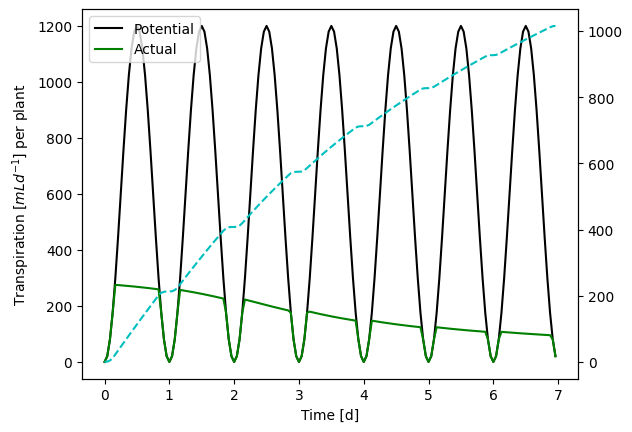

In [14]:
""" Transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiratio
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
plt.show()

In [9]:

vp.plot_roots_and_soil(hm.ms.mappedSegments(), "pressure head", hm.get_hs(h_bs), s, periodic, min_b, max_b, 
                       cell_number, interactiveImage = True)

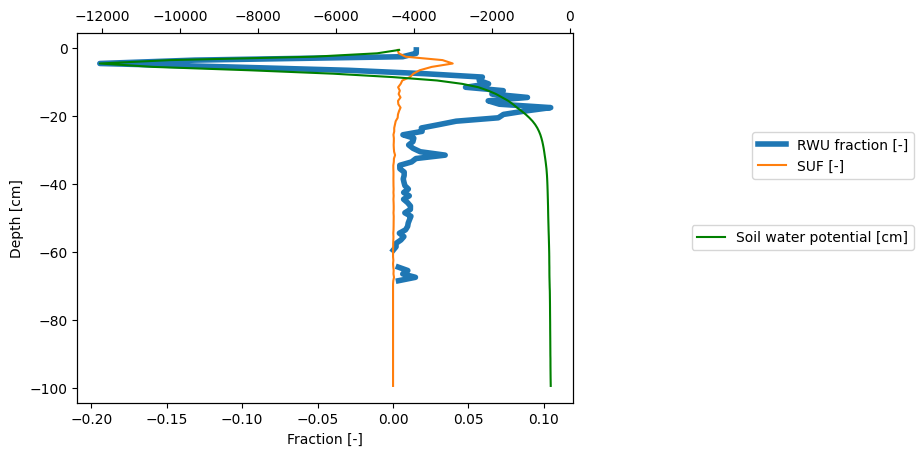

In [15]:
depth_array = [cc[2] for cc in s.getCellCenters()]
fig, ax1 = plt.subplots()
ax1.plot(q/np.nansum(q), depth_array,label = "RWU fraction [-]", linewidth=4 )  
ax1.plot(suf, depth_array, label = "SUF [-]")
ax2 = ax1.twiny()
ax2.plot(h_bs, depth_array, label="Soil water potential [cm]",color='g')  
ax1.set_xlabel("Fraction [-]")
ax1.set_ylabel("Depth [cm]")
ax1.legend(bbox_to_anchor=(1.7, 0.75))
ax2.legend(bbox_to_anchor=(1.7, 0.5))
plt.show()